Load in Data from .mat files

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

from processing_utils.feature_data_from_mat import load_subject_high_gamma

In [2]:
hg_trace, hg_map, phon_labels = load_subject_high_gamma('S14', sig_channel=False, zscore=False)

(149, 200, 111)
(149, 8, 16, 200)
(149, 3)


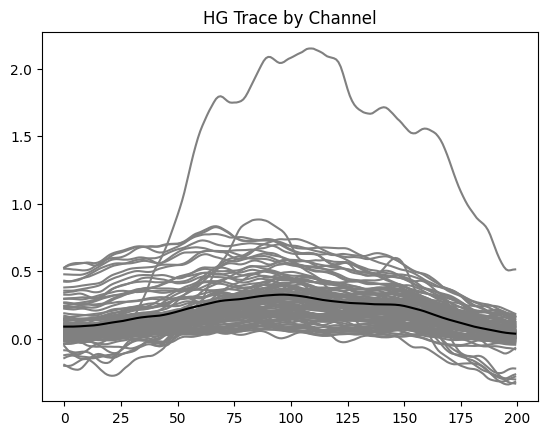

In [3]:
print(hg_trace.shape)
print(hg_map.shape)
print(phon_labels.shape)

plt.figure()
plt.plot(np.mean(hg_trace, axis=0), 'grey')
plt.plot(np.mean(np.mean(hg_trace, axis=0), axis=1), 'black')
plt.title('HG Trace by Channel')
plt.show()

Process data for use with 1/3 D CNN Bidirectional LSTM seq2seq

In [4]:
# imports
from processing_utils.sequence_processing import pad_sequence_teacher_forcing

In [5]:
# parameters
n_output = 10

In [6]:
X = hg_trace  # use HG traces (n_trials, n_channels, n_timepoints) for 1D CNN
# X = hg_map  # use HG channel map stack (n_trials, n_channels_x, n_channels_y, n_timepoints) for 1D CNN
X_prior, y, prior_labels, seq_labels = pad_sequence_teacher_forcing(phon_labels, n_output)  # first 2 outputs one-hot encoded

In [7]:
print(X.shape, X_prior.shape, y.shape, prior_labels.shape, seq_labels.shape)

(149, 200, 111) (149, 3, 10) (149, 3, 10) (149, 3) (149, 3)


Build 1D CNN Bidirectional LSTM seq2seq Model

In [8]:
# imports
from seq2seq_models.rnn_models import (lstm_1Dcnn_model, gru_1Dcnn_model, 
                                       lstm_3Dcnn_model, gru_3Dcnn_model)


In [9]:
# parameters

# 1D CNN
n_input_time = X.shape[1]
n_input_channel = X.shape[2]
filter_size = 10

# 3D CNN
# n_input_channel = [X.shape[1], X.shape[2]]
# n_input_time = X.shape[3]
# filter_size = 2

n_filters = 100
n_units = 800
reg_lambda = 1e-6
bidir = False

In [10]:
train_model, inf_enc, inf_dec = lstm_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)
# train_model, inf_enc, inf_dec = lstm_3Dcnn_model(n_input_time, n_input_x, n_input_y, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)
# train_model, inf_enc, inf_dec = gru_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)
# train_model, inf_enc, inf_dec = gru_3Dcnn_model(n_input_time, n_input_x, n_input_y, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)

In [11]:
print(train_model.summary())
print(train_model.layers[-1].summary())
print(inf_enc.summary())
print(inf_enc.layers[-1].summary())
print(inf_dec.summary())

Model: "training_lstm_final"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 111)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 20, 100)      111100      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None, 10)]   0           []                               
                                                                                                  
 training_lstm_initial (Functio  (None, None, 10)    5486410     ['conv1d[0][0]',                 
 nal)                                                             'input_2[0][0]

### Hyperparameter Optimization

In [12]:
import keras_tuner as kt
from train.optimize import encDecHyperModel, encDecTuner

In [13]:
hyper_model = encDecHyperModel(lstm_1Dcnn_model, n_input_time, n_input_channel, n_output)
rnn_optimizer = encDecTuner(hypermodel=hyper_model, oracle=kt.oracles.RandomSearchOracle(objective=kt.Objective('val_accuracy', direction='max'), max_trials=200), directory='data/rnn_tuning', project_name='S14_1Dcnn_LSTM')

In [14]:
rnn_optimizer.search(X, X_prior, y, epochs=800)

Trial 12 Complete [00h 16m 45s]
val_accuracy: 0.4132457163389977

Best val_accuracy So Far: 0.4132457163389977
Total elapsed time: 02h 18m 11s

Search: Running Trial #13

Value             |Best Value So Far |Hyperparameter
20                |10                |num_filts
4                 |4                 |filt_size
500               |700               |rnn_units
0.1               |1e-06             |reg_lambda
0.0001            |0.0001            |learning_rate
32                |32                |batch_size

========== Fold 1 ==========
Epoch 1/800
5/5 [==============================] - 3s 235ms/step - loss: 210.4945 - accuracy: 0.0647 - val_loss: 207.8886 - val_accuracy: 0.1111
Epoch 2/800
5/5 [==============================] - 0s 24ms/step - loss: 206.6918 - accuracy: 0.1194 - val_loss: 204.1626 - val_accuracy: 0.1556
Epoch 3/800
5/5 [==============================] - 0s 23ms/step - loss: 203.0060 - accuracy: 0.0970 - val_loss: 200.5527 - val_accuracy: 0.2000
Epoch 4/800
5/5 [==

KeyboardInterrupt: 

Train Model

In [12]:
# imports
from keras.optimizers import Adam
from train.train import train_seq2seq_kfold

In [20]:
# parameters
num_folds = 10
batch_size = 150
epochs = 500
learning_rate = 1e-5

train_model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
models, histories, y_pred_all, y_test_all = train_seq2seq_kfold(train_model, inf_enc, inf_dec, X, X_prior, y, num_folds=num_folds, batch_size=batch_size, epochs=epochs, early_stop=True)

========== Fold 1 ==========
Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 2.3715 - accuracy: 0.0846 - val_loss: 2.3586 - val_accuracy: 0.1111
Epoch 2/500
1/1 [==============================] - 0s 164ms/step - loss: 2.3656 - accuracy: 0.0846 - val_loss: 2.3528 - val_accuracy: 0.1111
Epoch 3/500
1/1 [==============================] - 0s 108ms/step - loss: 2.3598 - accuracy: 0.0846 - val_loss: 2.3472 - val_accuracy: 0.1111
Epoch 4/500
1/1 [==============================] - 0s 98ms/step - loss: 2.3540 - accuracy: 0.0846 - val_loss: 2.3417 - val_accuracy: 0.1111
Epoch 5/500
1/1 [==============================] - 0s 91ms/step - loss: 2.3484 - accuracy: 0.0846 - val_loss: 2.3362 - val_accuracy: 0.1111
Epoch 6/500
1/1 [==============================] - 0s 87ms/step - loss: 2.3429 - accuracy: 0.0846 - val_loss: 2.3308 - val_accuracy: 0.1111
Epoch 7/500
1/1 [==============================] - 0s 86ms/step - loss: 2.3375 - accuracy: 0.0846 - val_loss: 2.3256 - val_accuracy

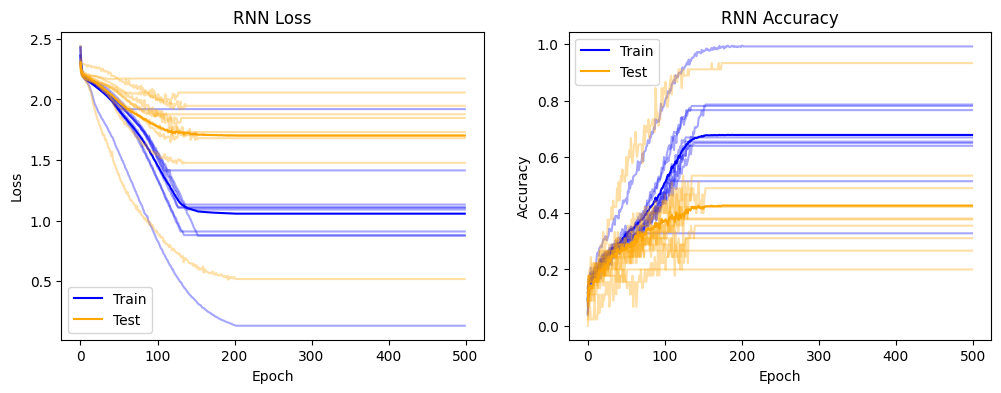

In [26]:
from visualization.plot_model_performance import extend_history_lists

histories = extend_history_lists(histories, epochs=epochs)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(np.array(histories['loss']).T, color='blue', alpha=0.35)
ax1.plot(np.mean(histories['loss'], axis=0), color='blue', label='Train')
ax1.plot(np.array(histories['val_loss']).T, color='orange', alpha=0.35)
ax1.plot(np.mean(histories['val_loss'], axis=0), color='orange', label='Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('RNN Loss')
ax1.legend()

ax2.plot(np.array(histories['accuracy']).T, color='blue', alpha=0.35)
ax2.plot(np.mean(histories['accuracy'], axis=0), color='blue', label='Train')
ax2.plot(np.array(histories['val_accuracy']).T, color='orange', alpha=0.35)
ax2.plot(np.mean(histories['val_accuracy'], axis=0), color='orange', label='Test')
# ax2.axhline(1/(n_output-1), color='gray', linestyle='--', label='Chance')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('RNN Accuracy')
ax2.legend()

plt.show()

In [29]:
from visualization.plot_model_performance import plot_accuracy_loss

plot_accuracy_loss(histories)

Fold 0 has more than 100 epochs. Pleaseextend histories lists to a value greater than or equalto the maximum number of epochs for any fold.
Fold 0 has more than 100 epochs. Pleaseextend histories lists to a value greater than or equalto the maximum number of epochs for any fold.
Fold 0 has more than 100 epochs. Pleaseextend histories lists to a value greater than or equalto the maximum number of epochs for any fold.
Fold 0 has more than 100 epochs. Pleaseextend histories lists to a value greater than or equalto the maximum number of epochs for any fold.
